In [4]:
import pandas as pd
df = pd.read_parquet("C:/Users/andya/Downloads/dffeatures.parquet")
df

,volume,vwap,open,close,high,low,timestamp,transactions,datetime,ticker,minute,hour,dayofweek,is_open_hour,hl_spread,oc_return,log_return,close_lag1,close_roll_mean_5,volume_roll_std_15
0,17632.0,137.0174,137.420,137.2600,137.565,136.85,1680528600000,105,2023-04-03 13:30:00,A,30,13,0,True,0.715,-0.001164,NaN,NaN,NaN,NaN
1,1011.0,137.2530,137.255,137.3200,137.320,137.25,1680528660000,28,2023-04-03 13:31:00,A,31,13,0,True,0.070,0.000474,0.000437,137.260,NaN,NaN
2,697.0,137.2364,137.220,137.3300,137.330,136.95,1680528720000,18,2023-04-03 13:32:00,A,32,13,0,True,0.380,0.000802,0.000073,137.320,NaN,NaN
3,4004.0,137.3055,136.990,137.5700,137.570,136.99,1680528780000,79,2023-04-03 13:33:00,A,33,13,0,True,0.580,0.004234,0.001746,137.330,NaN,NaN
4,7244.0,137.4399,137.690,137.3784,137.720,137.11,1680528840000,107,2023-04-03 13:34:00,A,34,13,0,True,0.610,-0.002263,-0.001394,137.570,137.37168,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
168836917,34617.0,161.8135,161.795,161.7600,161.910,161.74,1743537420000,553,2025-04-01 19:57:00,ZTS,57,19,1,False,0.170,-0.000216,-0.000216,161.795,161.83900,13551.869943
168836918,41392.0,161.7938,161.760,161.7600,161.825,161.73,1743537480000,658,2025-04-01 19:58:00,ZTS,58,19,1,False,0.095,0.000000,0.000000,161.760,161.83900,14366.357207
168836919,78248.0,161.7905,161.760,161.9400,161.950,161.68,1743537540000,1378,2025-04-01 19:59:00,ZTS,59,19,1,False,0.270,0.001113,0.001112,161.760,161.81500,20833.234937
168836920,17149.0,161.9100,161.910,161.9100,161.910,161.91,1743537600000,73,2025-04-01 20:00:00,ZTS,0,20,1,False,0.000,0.000000,-0.000185,161.940,161.83300,20488.876601


In [ ]:
df.head()

,volume,vwap,open,close,high,low,timestamp,transactions,datetime,ticker,minute,hour,dayofweek,is_open_hour,hl_spread,oc_return,log_return,close_lag1,close_roll_mean_5,volume_roll_std_15
0,17632.0,137.0174,137.420,137.2600,137.565,136.85,1680528600000,105,2023-04-03 13:30:00,A,30,13,0,True,0.715,-0.001164,NaN,NaN,NaN,NaN
1,1011.0,137.2530,137.255,137.3200,137.320,137.25,1680528660000,28,2023-04-03 13:31:00,A,31,13,0,True,0.070,0.000474,0.000437,137.26,NaN,NaN
2,697.0,137.2364,137.220,137.3300,137.330,136.95,1680528720000,18,2023-04-03 13:32:00,A,32,13,0,True,0.380,0.000802,0.000073,137.32,NaN,NaN
3,4004.0,137.3055,136.990,137.5700,137.570,136.99,1680528780000,79,2023-04-03 13:33:00,A,33,13,0,True,0.580,0.004234,0.001746,137.33,NaN,NaN
4,7244.0,137.4399,137.690,137.3784,137.720,137.11,1680528840000,107,2023-04-03 13:34:00,A,34,13,0,True,0.610,-0.002263,-0.001394,137.57,137.37168,NaN


In [2]:
import pandas as pd
data = pd.read_csv("C:/Users/andya/Downloads/merged_raw.csv")
data

,v,vw,o,c,h,l,t,n,datetime,ticker
0,17632.0,137.0174,137.420,137.2600,137.565,136.85,1680528600000,105,2023-04-03 13:30:00,A
1,1011.0,137.2530,137.255,137.3200,137.320,137.25,1680528660000,28,2023-04-03 13:31:00,A
2,697.0,137.2364,137.220,137.3300,137.330,136.95,1680528720000,18,2023-04-03 13:32:00,A
3,4004.0,137.3055,136.990,137.5700,137.570,136.99,1680528780000,79,2023-04-03 13:33:00,A
4,7244.0,137.4399,137.690,137.3784,137.720,137.11,1680528840000,107,2023-04-03 13:34:00,A
...,...,...,...,...,...,...,...,...,...,...
95428456,34617.0,161.8135,161.795,161.7600,161.910,161.74,1743537420000,553,2025-04-01 19:57:00,ZTS
95428457,41392.0,161.7938,161.760,161.7600,161.825,161.73,1743537480000,658,2025-04-01 19:58:00,ZTS
95428458,78248.0,161.7905,161.760,161.9400,161.950,161.68,1743537540000,1378,2025-04-01 19:59:00,ZTS
95428459,17149.0,161.9100,161.910,161.9100,161.910,161.91,1743537600000,73,2025-04-01 20:00:00,ZTS


In [ ]:
pip install pyspark findspark


Note: you may need to restart the kernel to use updated packages.


In [4]:
pip install duckdb

Note: you may need to restart the kernel to use updated packages.


   ---------------------------------------- 0.0/11.4 MB ? eta -:--:--
   --- ------------------------------------ 1.0/11.4 MB 10.1 MB/s eta 0:00:02
   ---------- ----------------------------- 2.9/11.4 MB 8.8 MB/s eta 0:00:01
   --------------- ------------------------ 4.5/11.4 MB 8.6 MB/s eta 0:00:01
   ----------------------- ---------------- 6.6/11.4 MB 8.8 MB/s eta 0:00:01
   ----------------------------- ---------- 8.4/11.4 MB 8.7 MB/s eta 0:00:01
   ------------------------------------- -- 10.7/11.4 MB 9.1 MB/s eta 0:00:01
   ---------------------------------------- 11.4/11.4 MB 9.1 MB/s eta 0:00:00


In [ ]:
import pandas as pd
import numpy as np
import duckdb

# 1. read csv and then parse datetime
df = pd.read_csv(
    "C:/Users/andya/Downloads/merged_raw.csv",
    parse_dates=["datetime"],
    infer_datetime_format=True
)

# 2. rename every column
df = df.rename(columns={
    "v":  "volume",
    "vw": "vwap",
    "o":  "open",
    "c":  "close",
    "h":  "high",
    "l":  "low",
    "t":  "timestamp",
    "n":  "transactions"
})

# 3. clean missing value
price_cols = ["open", "high", "low", "close"]
df[price_cols] = df.groupby("ticker")[price_cols].ffill()

df["volume"] = df["volume"].fillna(0)

# To fix the error, I use 'transform'to keep index
df["vwap"] = df.groupby("ticker")["vwap"] \
              .transform(lambda x: x.interpolate())

#  deal with time column
df["minute"]      = df["datetime"].dt.minute
df["hour"]        = df["datetime"].dt.hour
df["dayofweek"]   = df["datetime"].dt.dayofweek
df["is_open_hour"] = df["hour"].between(9, 16)

# 5. Use DuckDB to feature
con = duckdb.connect(database=":memory:")
con.register("raw", df)

q = """
SELECT
  *,
  high - low                              AS hl_spread,
  (close - open) / open                   AS oc_return,
  LOG(close / LAG(close) OVER win1)       AS log_return,
  LAG(close) OVER win1                    AS close_lag1,
  AVG(close) OVER win5                    AS close_roll_mean_5,
  STDDEV_POP(volume) OVER win15           AS volume_roll_std_15
FROM raw
WINDOW
  win1 AS (PARTITION BY ticker ORDER BY datetime ROWS BETWEEN 1 PRECEDING AND CURRENT ROW),
  win5 AS (PARTITION BY ticker ORDER BY datetime ROWS BETWEEN 4 PRECEDING AND CURRENT ROW),
  win15 AS (PARTITION BY ticker ORDER BY datetime ROWS BETWEEN 14 PRECEDING AND CURRENT ROW)
ORDER BY ticker, datetime
"""
df_features = con.execute(q).df()

# 6. get Parquet
df_features.to_parquet(
    "C:/Users/andya/Downloads/dffeatures_duckdb.parquet",
    index=False
)

#run 19 min


C:\Users\andya\AppData\Local\Temp\ipykernel_3636\3239482965.py:6: FutureWarning: The argument 'infer_datetime_format' is deprecated and will be removed in a future version. A strict version of it is now the default, see https://pandas.pydata.org/pdeps/0004-consistent-to-datetime-parsing.html. You can safely remove this argument.
  df = pd.read_csv(


In [2]:
import pandas as pd
df = pd.read_parquet("C:/Users/andya/Downloads/dffeatures_duckdb.parquet")

df = df[df['ticker'] != 'merged_raw']#When checking the data, we find that there is strange ticker, so I delete it!
df

,volume,vwap,open,close,high,low,timestamp,transactions,datetime,ticker,minute,hour,dayofweek,is_open_hour,hl_spread,oc_return,log_return,close_lag1,close_roll_mean_5,volume_roll_std_15
0,17632.0,137.0174,137.420,137.2600,137.565,136.85,1680528600000,105,2023-04-03 13:30:00,A,30,13,0,True,0.715,-0.001164,NaN,NaN,137.260000,0.000000
1,1011.0,137.2530,137.255,137.3200,137.320,137.25,1680528660000,28,2023-04-03 13:31:00,A,31,13,0,True,0.070,0.000474,0.000190,137.260,137.290000,8310.500000
2,697.0,137.2364,137.220,137.3300,137.330,136.95,1680528720000,18,2023-04-03 13:32:00,A,32,13,0,True,0.380,0.000802,0.000032,137.320,137.303333,7910.263811
3,4004.0,137.3055,136.990,137.5700,137.570,136.99,1680528780000,79,2023-04-03 13:33:00,A,33,13,0,True,0.580,0.004234,0.000758,137.330,137.370000,6931.662607
4,7244.0,137.4399,137.690,137.3784,137.720,137.11,1680528840000,107,2023-04-03 13:34:00,A,34,13,0,True,0.610,-0.002263,-0.000605,137.570,137.371680,6225.395685
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
84418456,34617.0,161.8135,161.795,161.7600,161.910,161.74,1743537420000,553,2025-04-01 19:57:00,ZTS,57,19,1,False,0.170,-0.000216,-0.000094,161.795,161.839000,13092.350197
84418457,41392.0,161.7938,161.760,161.7600,161.825,161.73,1743537480000,658,2025-04-01 19:58:00,ZTS,58,19,1,False,0.095,0.000000,0.000000,161.760,161.839000,13879.219651
84418458,78248.0,161.7905,161.760,161.9400,161.950,161.68,1743537540000,1378,2025-04-01 19:59:00,ZTS,59,19,1,False,0.270,0.001113,0.000483,161.760,161.815000,20126.817088
84418459,17149.0,161.9100,161.910,161.9100,161.910,161.91,1743537600000,73,2025-04-01 20:00:00,ZTS,0,20,1,False,0.000,0.000000,-0.000080,161.940,161.833000,19794.135329


In [2]:
!pip install "dask[complete]" hvplot matplotlib


   ---------------------------------------- 0.0/1.5 MB ? eta -:--:--
   ---------------------------- ----------- 1.0/1.5 MB 7.1 MB/s eta 0:00:01
   ---------------------------------------- 1.5/1.5 MB 7.0 MB/s eta 0:00:00
   ---------------------------------------- 0.0/7.0 MB ? eta -:--:--
   ---- ----------------------------------- 0.8/7.0 MB 3.4 MB/s eta 0:00:02
   ----------- ---------------------------- 2.1/7.0 MB 5.6 MB/s eta 0:00:01
   ---------------------- ----------------- 3.9/7.0 MB 6.5 MB/s eta 0:00:01
   ------------------------------- -------- 5.5/7.0 MB 7.1 MB/s eta 0:00:01
   ---------------------------------------- 7.0/7.0 MB 7.3 MB/s eta 0:00:00
   ---------------------------------------- 0.0/5.0 MB ? eta -:--:--
   ------------ --------------------------- 1.6/5.0 MB 8.4 MB/s eta 0:00:01
   ------------------------- -------------- 3.1/5.0 MB 8.8 MB/s eta 0:00:01
   ---------------------------------------  5.0/5.0 MB 8.4 MB/s eta 0:00:01
   ------------------------------

In [ ]:
#use dask
import dask.dataframe as dd
from dask.distributed import Client
import matplotlib.pyplot as plt

client = Client()                      
ddf = dd.from_pandas(df, npartitions=8)
ddf["ticker"] = ddf["ticker"].astype(str).str.strip()


c:\Users\andya\AppData\Local\Programs\Python\Python312\Lib\site-packages\distributed\node.py:187: UserWarning: Port 8787 is already in use.
Perhaps you already have a cluster running?
Hosting the HTTP server on port 58224 instead
  warnings.warn(


c:\Users\andya\AppData\Local\Programs\Python\Python312\Lib\site-packages\distributed\client.py:3357: UserWarning: Sending large graph of size 11.39 GiB.
This may cause some slowdown.
Consider loading the data with Dask directly
 or using futures or delayed objects to embed the data into the graph without repetition.
See also https://docs.dask.org/en/stable/best-practices.html#load-data-with-dask for more information.
  warnings.warn(


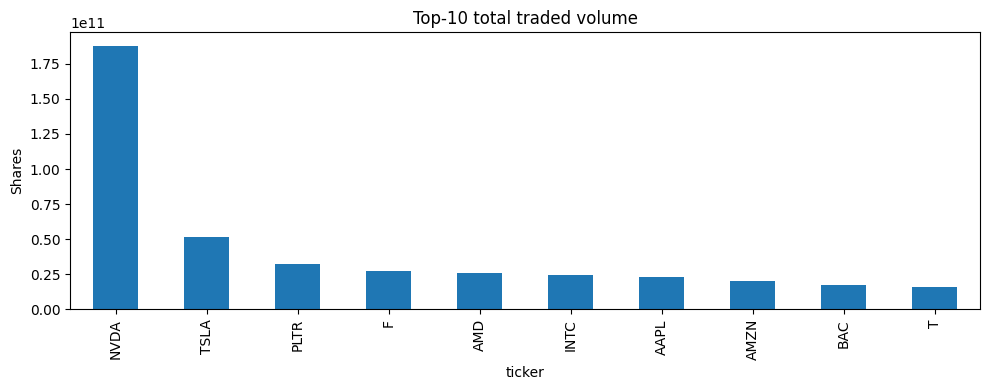

In [ ]:
# Observe the top 10 total trading volume

topN = (
    ddf.groupby("ticker")["volume"]
       .sum()
       .nlargest(10)
       .compute()
       .sort_values(ascending=False)
)

plt.figure(figsize=(10,4))
topN.plot(kind="bar")
plt.title("Top‑10 total traded volume")
plt.ylabel("Shares")
plt.tight_layout()
plt.show()


c:\Users\andya\AppData\Local\Programs\Python\Python312\Lib\site-packages\distributed\client.py:3357: UserWarning: Sending large graph of size 11.38 GiB.
This may cause some slowdown.
Consider loading the data with Dask directly
 or using futures or delayed objects to embed the data into the graph without repetition.
See also https://docs.dask.org/en/stable/best-practices.html#load-data-with-dask for more information.
  warnings.warn(


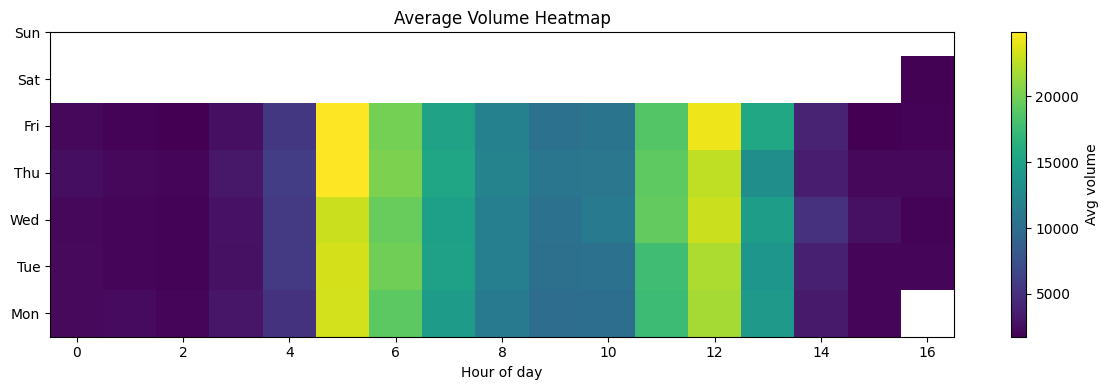

In [ ]:
# Averaging trading volume (Day‑of‑Week × Hour)
intraday = (
    ddf.groupby(["dayofweek", "hour"])["volume"]
       .mean()
       .compute()
       .unstack()
       .sort_index()
)

plt.figure(figsize=(12,4))
plt.imshow(intraday, aspect="auto", origin="lower", cmap="viridis")
plt.colorbar(label="Avg volume")
plt.yticks(range(7), ["Mon","Tue","Wed","Thu","Fri","Sat","Sun"])
plt.xlabel("Hour of day")
plt.title("Average Volume Heatmap")
plt.tight_layout()
plt.show()


The final row in  heatmap (dayofweek=5, Saturday) showing a colored bar at hour 16 is because our underlying minute-level dataset actually contains weekend timestamps (dayofweek values of 5 and 6), so when we groupby dayofweek and hour, it ends up computing and displaying average volumes for Saturdays (and Sundays) as well.

c:\Users\andya\AppData\Local\Programs\Python\Python312\Lib\site-packages\distributed\client.py:3357: UserWarning: Sending large graph of size 11.38 GiB.
This may cause some slowdown.
Consider loading the data with Dask directly
 or using futures or delayed objects to embed the data into the graph without repetition.
See also https://docs.dask.org/en/stable/best-practices.html#load-data-with-dask for more information.
  warnings.warn(


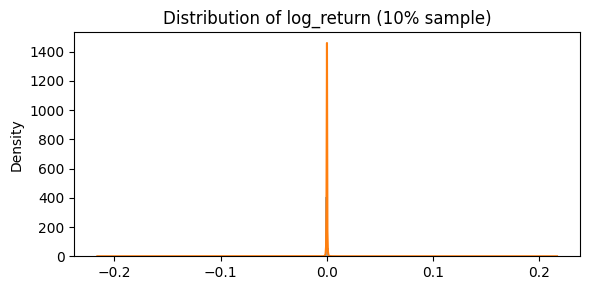

In [ ]:
import scipy
# Cell 4 ▶︎ log_return dist. 10% random sampling
sample = (
    ddf["log_return"]
    .dropna()
    .sample(frac=0.10, random_state=42)
    .compute()
)

plt.figure(figsize=(6,3))
sample.hist(bins=100, density=True, alpha=0.6)
sample.plot(kind="kde")
plt.title("Distribution of log_return (10% sample)")
plt.tight_layout()
plt.show()


This sharp spike at zero is actually expected when you aggregate minute-level returns across all tickers:

Most minutes there’s no price change, so log_return == 0 dominates and appears as a “needle” at 0 in your histogram/KDE.

Only when a stock’s price moves within a minute do you get non-zero returns, which are relatively rare and spread out in the ±0.001–±0.02 range.

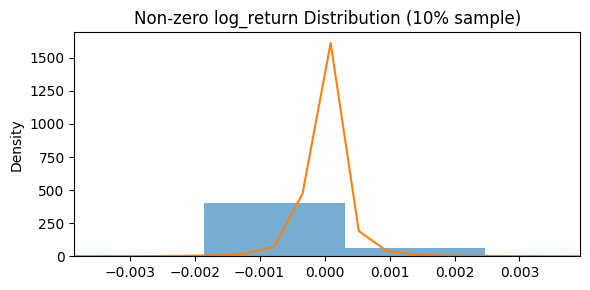

In [9]:
# assume `sample` is your 10% draw of log_return from Cell 4
nonzero = sample[sample != 0]

plt.figure(figsize=(6, 3))
nonzero.hist(bins=100, density=True, alpha=0.6)
nonzero.plot(kind="kde")
plt.title("Non-zero log_return Distribution (10% sample)")
# zoom in between the 0.1% and 99.9% quantiles to ignore extreme outliers
plt.xlim(nonzero.quantile(0.001), nonzero.quantile(0.999))
plt.tight_layout()
plt.show()


This “tails‐only” plot tells us a few things about the minute-level non-zero returns:

Even after filtering out the exact zeros, the remaining minute‐level returns remain overwhelmingly concentrated in tiny “micro‐ticks” of roughly ±0.0002 to ±0.0005, which produces the tall, narrow peak at zero. However, when you zoom in you still observe non‐negligible “medium” moves in the ±0.001 to ±0.0025 range—far more than a Gaussian with the same variance would predict—revealing pronounced fat tails. The distribution is nearly symmetric but exhibits a slight negative skew, since down‐moves just below –0.001 occur a bit more often or with slightly larger magnitudes than up‐moves above +0.001. Because of these heavy tails and mild skew, any volatility model or VaR calculation that assumes pure normality will understate both the frequency of moderate jumps and the true probability of seeing 2–3 bps spikes; a more appropriate approach is therefore to use historical simulation or a heavy‐tailed parametric fit (e.g. a Student’s t or jump‐diffusion model) to capture the full risk.

In [ ]:
#Calculate mean, stdev, skew and Kurtosis
import pandas as pd
nonzero = df['log_return'][df['log_return'] != 0]
stats = pd.Series({
    'count':   nonzero.size,
    'mean':    nonzero.mean(),
    'std':     nonzero.std(),
    'skew':    nonzero.skew(),
    'kurtosis':nonzero.kurtosis(),  
})
print(stats)


count       7.642522e+07
mean        7.016867e-07
std         6.200321e-04
skew        1.817298e+00
kurtosis    2.019652e+06
dtype: float64


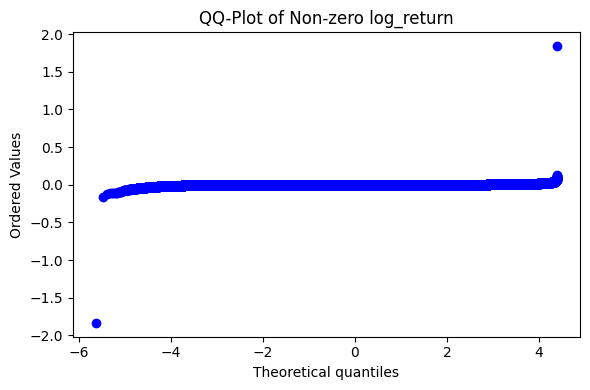

In [12]:
 # QQ-plot vs normal dist.
import scipy.stats as st
import matplotlib.pyplot as plt

plt.figure(figsize=(6,4))
st.probplot(nonzero, dist="norm", plot=plt)
plt.title("QQ-Plot of Non-zero log_return")
plt.tight_layout()
plt.show()


The QQ‐plot shows that while the bulk of non‐zero minute‐returns aligns closely with a Normal distribution, but both tails deviate markedly. We can observe that extreme negative returns fall far below the line and extreme positive returns rise well above it. This “fat‐tail” behavior—especially the slightly heavier left  tail—demonstrates that a Gaussian model would significantly underestimate the frequency and magnitude of extreme price moves.

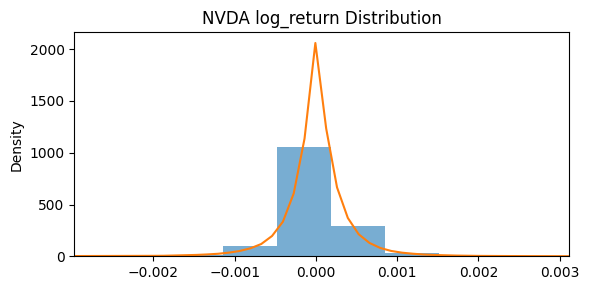

In [10]:
top1 = topN.index[0]               # highest-volume ticker from Cell 2
sub = df[df['ticker'] == top1]['log_return'].dropna()

plt.figure(figsize=(6, 3))
sub.hist(bins=100, density=True, alpha=0.6)
sub.plot(kind="kde")
plt.title(f"{top1} log_return Distribution")
plt.xlim(sub.quantile(0.001), sub.quantile(0.999))
plt.tight_layout()
plt.show()


In [ ]:
# Calculate NVDA log_return's skew & kurtosis
import pandas as pd
sub = df.loc[df['ticker']=='NVDA', 'log_return'].dropna()


skewness = sub.skew()

print(f"NVDA log_return (skewness): {skewness:.4f}")
print(f"NVDA log_return (excess kurtosis): {kurtosis:.4f}") #definition in pandas 

import numpy as np

# 95% VaR → alpha=0.05
alpha1 = 0.05
var95 = sub.quantile(alpha1)
cvar95 = sub[sub <= var95].mean()

# 99% VaR → alpha=0.01
alpha2 = 0.01
var99 = sub.quantile(alpha2)
cvar99 = sub[sub <= var99].mean()

print(f"NVDA  95% Historical VaR  : {var95:.4%}  （5% ）")
print(f"NVDA  95% Historical CVaR : {cvar95:.4%}  （Average 5% tail）\n")
print(f"NVDA  99% Historical VaR  : {var99:.4%}  （1% ）")
print(f"NVDA  99% Historical CVaR : {cvar99:.4%}  （Average 1% tail）")


NVDA log_return (skewness): -1.2925
NVDA log_return (excess kurtosis): 350.3298
NVDA  95% Historical VaR  : -0.0616%  （5% ）
NVDA  95% Historical CVaR : -0.1093%  （Average 5% tail）

NVDA  99% Historical VaR  : -0.1306%  （1% ）
NVDA  99% Historical CVaR : -0.2066%  （Average 1% tail）


c:\Users\andya\AppData\Local\Programs\Python\Python312\Lib\site-packages\distributed\client.py:3357: UserWarning: Sending large graph of size 11.39 GiB.
This may cause some slowdown.
Consider loading the data with Dask directly
 or using futures or delayed objects to embed the data into the graph without repetition.
See also https://docs.dask.org/en/stable/best-practices.html#load-data-with-dask for more information.
  warnings.warn(


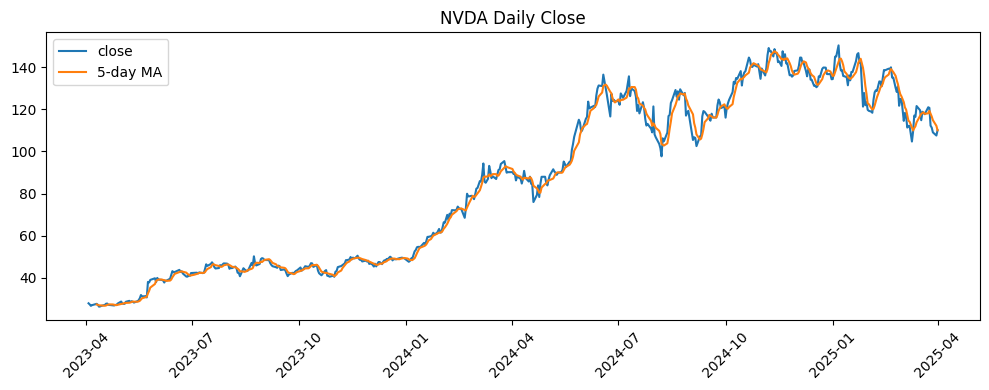

In [ ]:
#Comparing close and MA5
top_ticker = topN.index[0]
subset = ddf[ddf["ticker"] == top_ticker][["datetime", "close"]]

subset["date"] = dd.to_datetime(subset["datetime"]).dt.date
daily_close = (
    subset.groupby("date")["close"]
          .last()
          .compute()
          .sort_index()
)

roll5 = daily_close.rolling(5).mean()

plt.figure(figsize=(10,4))
plt.plot(daily_close.index, daily_close.values, label="close")
plt.plot(roll5.index, roll5.values, label="5‑day MA")
plt.title(f"{top_ticker} Daily Close")
plt.legend()
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


Because the minute-level noise is small, a 5-day average moves nearly in parallel with the closing price. The short MA window and low day-to-day dispersion make the two lines effectively overlap on a daily chart.